# Setup and imports

In [1]:
# Watch out for dependency issues w/ np. We will solve this by restarting the session when asked

from google.colab import userdata     # Imports secret tokens for logins
from huggingface_hub import login     # Huggingface for fast implementation of transformers

secrets = {
    'hugging': userdata.get('hugging_token'),
    'lens': userdata.get('HF_TOKEN'),
    'wandb': userdata.get('wandb_api')
}

login(token=secrets['hugging'])

import pkg_resources
installed_packages = [pkg.key for pkg in pkg_resources.working_set]
if "transformer-lens" not in installed_packages:
    %pip install transformer_lens==2.11.0 einops eindex-callum jaxtyping git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python
    # TO DO: add other installs here
elif "wandb" not in installed_packages:
    %pip install wandb -qU
elif "datasets" not in installed_packages:
    %pip install datasets
elif "bitsandbytes" not in installed_packages:
    %pip install -U bitsandbytes
elif "accelerate" not in installed_packages:
    %pip install -U accelerate
elif "transformers" not in installed_packages:
    %pip install -U transformers

%pip install sae-lens git+https://github.com/callummcdougall/sae_vis.git@callum/v3

''' Navigate drive '''

import os
import sys
from pathlib import Path
file_path = ('/content/drive/My Drive/belief-repr-1/')
sys.path.append(file_path)
import json
import pickle
from google.colab import drive
drive.mount('/content/drive')

''' For importing datasets '''

from datasets import load_dataset


<ipython-input-1-babeebebb587>:14: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


  Cloning https://github.com/callummcdougall/sae_vis.git (to revision callum/v3) to /tmp/pip-req-build-ok7qt7xq
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/sae_vis.git /tmp/pip-req-build-ok7qt7xq
  Running command git checkout -b callum/v3 --track origin/callum/v3
  Switched to a new branch 'callum/v3'
  Branch 'callum/v3' set up to track remote branch 'callum/v3' from 'origin'.
  Resolved https://github.com/callummcdougall/sae_vis.git to commit 2e8e0742d481d582a2028cd4910673a74dcce337
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Mounted at /content/drive


In [2]:
import transformer_lens as tlens

'''
TransformerLens is Neel's amazing library for easy access to transformer's activations | Bootstrap here: https://transformerlensorg.github.io/TransformerLens/generated/demos/Main_Demo.html
Some useful methods include:

ActivationCache | https://transformerlensorg.github.io/TransformerLens/generated/code/transformer_lens.ActivationCache.html
HookedTransformer | https://transformerlensorg.github.io/TransformerLens/generated/code/transformer_lens.HookedTransformer.html
  --- There are some variants based on the model, meant to wrap the relevant architecture ---
  HookedEncoder | https://transformerlensorg.github.io/TransformerLens/generated/code/transformer_lens.HookedEncoder.html
  BertNextSentencePrediction | https://transformerlensorg.github.io/TransformerLens/generated/code/transformer_lens.BertNextSentencePrediction.html
  HookedEncoderDecoder | https://transformerlensorg.github.io/TransformerLens/generated/code/transformer_lens.HookedEncoderDecoder.html
patching | https://transformerlensorg.github.io/TransformerLens/generated/code/transformer_lens.patching.html
train | https://transformerlensorg.github.io/TransformerLens/generated/code/transformer_lens.train.html

and more (see documentation)
'''

import sae_lens as slens
from sae_lens import (
    SAE,
    ActivationsStore,
    HookedSAETransformer,
    LanguageModelSAERunnerConfig,
    SAEConfig,
    SAETrainingRunner,
    upload_saes_to_huggingface,
)
from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory
from sae_vis import SaeVisConfig, SaeVisData, SaeVisLayoutConfig

'''
Like TransformerLens, but for SAEs
Some useful methods include:

# Fill

and more (see documentation)
'''

import circuitsvis as cv

'''
Visualization tool tailored on transformers.
We can use it to visualize:

Neuron activations | https://transformerlensorg.github.io/CircuitsVis/?path=/docs/activations-textneuronactivations--multiple-samples
Attention heads | https://transformerlensorg.github.io/CircuitsVis/?path=/docs/attention-attentionheads--induction-heads-layer
Logprobs for next tokens | https://transformerlensorg.github.io/CircuitsVis/?path=/docs/logits-tokenlogprobs--small-model-example
Top K samples/tokens per neuron | https://transformerlensorg.github.io/CircuitsVis/?path=/docs/topk-topksamples--example-samples
'''

import einops
from einops import einsum

'''
For tensor manipulation. Key methods:
Repeat | e. g. einops.repeat(tensor, 'batch seq_len d_model -> batch (repeat seq_len) d_model', repeat=3) | https://einops.rocks/api/repeat/
Rearrange | e. g. einops.rearrange(tensor, 'batch seq_len d_model -> batch d_model seq_len')| https://einops.rocks/api/rearrange/
Reduce | e. g. einops.reduce(tensor, 'batch seq_len d_model -> batch seq_len', 'mean') | https://einops.rocks/api/reduce/
Einsum | e. g. einsum(tensor_1, tensor_2, 'batch seq_len d_model, n_head d_head -> batch seq_len n_head' )  | https://einops.rocks/api/einsum/
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as t                     # https://pytorch.org/docs/stable/torch.html
import torch.nn as nn                 # https://pytorch.org/docs/stable/nn.html
import torch.nn.functional as F       # https://pytorch.org/docs/stable/nn.functional.html
from rich import print as rprint
from rich.table import Column, Table
from functools import partial         # We need this for fwd_hooks

''' Utils '''

from jaxtyping import Float, Int
from torch import Tensor
from typing import Callable

''' Should we need strongly typing '''

import tqdm                           # Useful for cellwise progress bar wrappers
from tqdm import tqdm
import wandb                          # REMEMBER to log training loops if you want to analyze that behavior | how to: wandb.init() before training, wandb.log() at each epoch, wandb.finish() to clean cache
wandb.login()

''' For visualization of progress (in notebook) and training behavior (in wandb) '''

device = t.device("mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu")

''' My probes (Fetch the file)'''
# from probes import *

''' My hooks (Fetch the file) '''
from hooks import *

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: alessandro-corona-m (alessandro-corona) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
class Config():
    def __init__(self):
        # General settings
        self.param = "param"

class ModelConfig(Config):
    def __init__(self):
      super().__init__()
      self.model_param = "param"

''' Dictionary for all of the models '''

mymodels = {
    'llama': lambda: tlens.HookedTransformer.from_pretrained("meta-llama/Llama-3.1-8B", device=device),
    'gpt': lambda: tlens.HookedTransformer.from_pretrained("gpt2-medium", device=device),
    'bert': lambda: tlens.HookedTransformer.from_pretrained("bert-large-uncased", device=device),
    'mistral': lambda: tlens.HookedTransformer.from_pretrained("mistral-7b", device=device),
    'mistral_instruct': lambda: tlens.HookedTransformer.from_pretrained("mistral-7b-instruct", device=device),
    'gemma': lambda: tlens.HookedTransformer.from_pretrained("gemma-2-9b", device=device),
}

# Usage example:
model = mymodels['gpt']()

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-medium into HookedTransformer


## Let's play with Tlens (GPT)

In [4]:
gpt2_text = "Natural language processing tasks, such as question answering, machine translation, reading comprehension, and summarization, are typically approached with supervised learning on taskspecific datasets."
gpt2_tokens = model.to_tokens(gpt2_text)
print(gpt2_tokens.device)
gpt2_logits, gpt2_cache = model.run_with_cache(gpt2_tokens, remove_batch_dim=True)

cpu


In [5]:
print("= = = HIGH LEVEL OVERVIEW = = =")
print()
print("Call embedding_in (seq, d_model)", gpt2_cache['embed'].shape)
print("Call embedding+pos (seq, d_model)", gpt2_cache['pos_embed'].shape)
print("Residual stream at each layer (seq, d_model)", [gpt2_cache[('resid_pre', layer)].shape for layer in range(model.cfg.n_layers)])
print("Are resid_post(l_n) and resid_pre(l_n+1) the same?", t.equal(gpt2_cache[('resid_post', 0)], gpt2_cache[('resid_pre', 1)]))
print("Call last layernorm scale (seq, 1)", gpt2_cache['ln_final.hook_scale'].shape)
print("Call last layernorm normalized (seq, d_model)", gpt2_cache['ln_final.hook_normalized'].shape)
print("Call Logits (batch, seq, vocab):", gpt2_logits.shape)
print()
print("= = = TRANSFORMER BLOCK = = =")
print()
print("... residual stream pre ...")
print()
print("Call First Layer Norm scale (seq, 1)",  gpt2_cache['scale0ln1'].shape)
print("Call First Layer Norm (seq, d_model)",  gpt2_cache['normalized0ln1'].shape)
print()
print("... goes inside attn block ...")
print("... residual stream mid ...")
print()
print("Call Second Layer Norm scale (seq, 1)", gpt2_cache['scale0ln2'].shape)
print("Call Second Layer Norm (seq, d_model)", gpt2_cache['normalized0ln2'].shape)
print()
print("... goes inside MLP ...")
print("... residual stream post ...")
print()
print("= = = ATTN BLOCK = = =")
print()
print("... residaul stream pre ...")
print("Call Q (seq, n_head, d_head)", gpt2_cache['q', 0].shape)
print("Call K (seq, n_head, d_head)", gpt2_cache['k', 0].shape)
print("Call V (seq, n_head, d_head)", gpt2_cache['v', 0].shape)
print("Call scores (n_head, seq, seq)", gpt2_cache['attn_scores', 0].shape)
print("Call pattern (n_head, seq, seq)", gpt2_cache['pattern', 0].shape)
print("Call z (seq, n_head, d_head)", gpt2_cache['z', 0].shape)
print("Call attn_out (seq, d_model)", gpt2_cache['attn_out', 0].shape)
print("... residual stream mid ...")
print()
print("= = = MLP = = =")
print()
print("... residual stream mid ...")
print("Call MLP pre (seq, d_model * 4)", gpt2_cache['mlp_pre', 0].shape)
print("Call MLP post LU (seq, d_model * 4)", gpt2_cache['mlp_post', 0].shape)
print("Call MLP out (seq, d_model)", gpt2_cache['mlp_out', 0].shape)
print("... residual stream post ...")

= = = HIGH LEVEL OVERVIEW = = =

Call embedding_in (seq, d_model) torch.Size([33, 1024])
Call embedding+pos (seq, d_model) torch.Size([33, 1024])
Residual stream at each layer (seq, d_model) [torch.Size([33, 1024]), torch.Size([33, 1024]), torch.Size([33, 1024]), torch.Size([33, 1024]), torch.Size([33, 1024]), torch.Size([33, 1024]), torch.Size([33, 1024]), torch.Size([33, 1024]), torch.Size([33, 1024]), torch.Size([33, 1024]), torch.Size([33, 1024]), torch.Size([33, 1024]), torch.Size([33, 1024]), torch.Size([33, 1024]), torch.Size([33, 1024]), torch.Size([33, 1024]), torch.Size([33, 1024]), torch.Size([33, 1024]), torch.Size([33, 1024]), torch.Size([33, 1024]), torch.Size([33, 1024]), torch.Size([33, 1024]), torch.Size([33, 1024]), torch.Size([33, 1024])]
Are resid_post(l_n) and resid_pre(l_n+1) the same? True
Call last layernorm scale (seq, 1) torch.Size([33, 1])
Call last layernorm normalized (seq, d_model) torch.Size([33, 1024])
Call Logits (batch, seq, vocab): torch.Size([1, 33, 

In [6]:
test_prompt = "The quick brown fox jumped over the lazy dog"
print("Num tokens:", len(model.to_tokens(test_prompt)[0]))

def print_name_shape_hook_function(activation, hook):
    print(hook.name, activation.shape)

not_in_late_block_filter = lambda name: name.startswith("blocks.0.") or not name.startswith("blocks")

model.run_with_hooks(
    test_prompt,
    return_type=None,
    fwd_hooks=[(not_in_late_block_filter, print_name_shape_hook_function)],
)

Num tokens: 10
hook_embed torch.Size([1, 10, 1024])
hook_pos_embed torch.Size([1, 10, 1024])
blocks.0.hook_resid_pre torch.Size([1, 10, 1024])
blocks.0.ln1.hook_scale torch.Size([1, 10, 1])
blocks.0.ln1.hook_normalized torch.Size([1, 10, 1024])
blocks.0.ln1.hook_scale torch.Size([1, 10, 1])
blocks.0.ln1.hook_normalized torch.Size([1, 10, 1024])
blocks.0.ln1.hook_scale torch.Size([1, 10, 1])
blocks.0.ln1.hook_normalized torch.Size([1, 10, 1024])
blocks.0.attn.hook_q torch.Size([1, 10, 16, 64])
blocks.0.attn.hook_k torch.Size([1, 10, 16, 64])
blocks.0.attn.hook_v torch.Size([1, 10, 16, 64])
blocks.0.attn.hook_attn_scores torch.Size([1, 16, 10, 10])
blocks.0.attn.hook_pattern torch.Size([1, 16, 10, 10])
blocks.0.attn.hook_z torch.Size([1, 10, 16, 64])
blocks.0.hook_attn_out torch.Size([1, 10, 1024])
blocks.0.hook_resid_mid torch.Size([1, 10, 1024])
blocks.0.ln2.hook_scale torch.Size([1, 10, 1])
blocks.0.ln2.hook_normalized torch.Size([1, 10, 1024])
blocks.0.mlp.hook_pre torch.Size([1, 10,

In [8]:
model.reset_hooks()
original_loss = model(test_prompt, return_type="loss")
ablated_loss = model.run_with_hooks(
    gpt2_tokens,
    return_type="loss",
    fwd_hooks=[(
        tlens.utils.get_act_name("v", 0),
        partial(head_ablation_hook, head_index_to_ablate=8)   # We need partials since fwd_hooks only accepts callables as arguments
        )]
    )
print(f"Original Loss: {original_loss.item():.3f}")
print(f"Ablated Loss: {ablated_loss.item():.3f}")

Shape of the value tensor: torch.Size([1, 33, 16, 64])
Original Loss: 2.352
Ablated Loss: 3.755


![transformer-full-updated[1].png](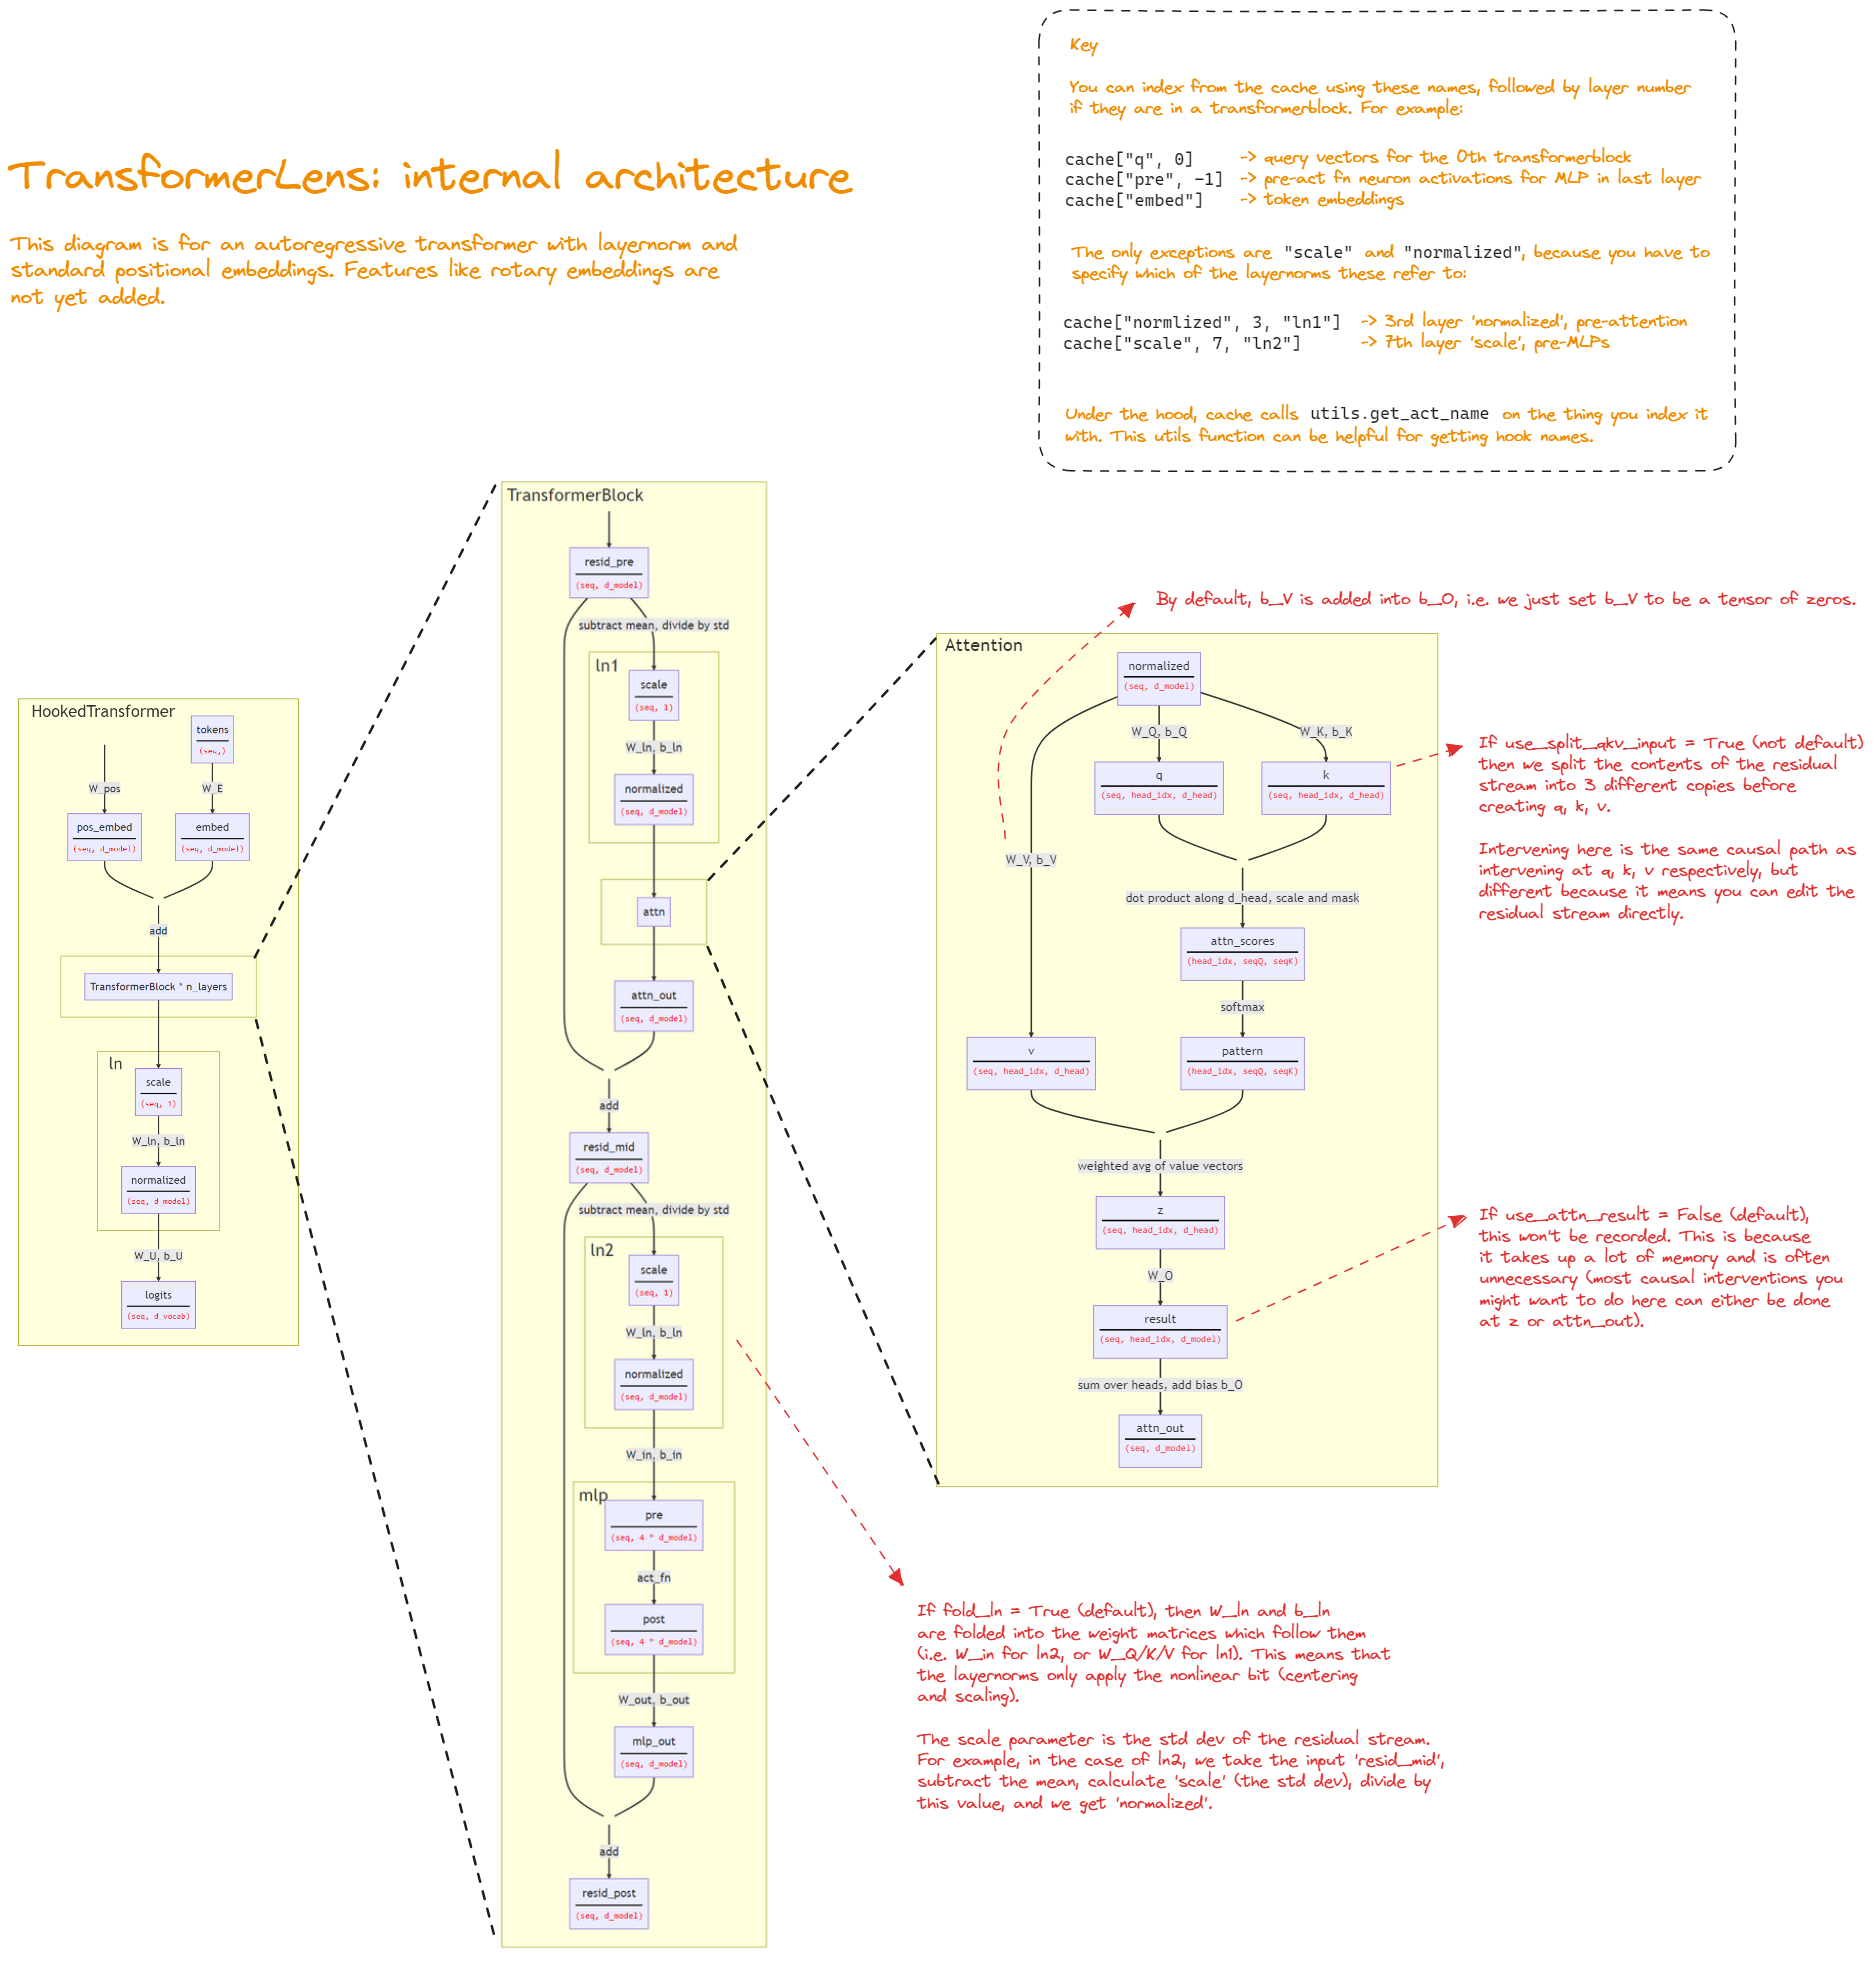)

# Techniques Roundup

## Intervention

### Ablation

#### Zero

#### Mean

### Steering

## Patching

## Logit Attribution

### Logit Lens

## Probing

### Concept activation

## SAE

## Layer-wise Relevance Propagation/DeepLIFT

## Attention

### Roll-out

### Flow

### Layer-wise attention tracing

### Decoding

## Correlation of representation & Clustering

## Training on a classification task

## LIT

## Causal scrubbing


# Datasets

In [4]:
from data_sets import *

ModuleNotFoundError: No module named 'data_sets'

# Models

## Warmup

In [ ]:
gpt2_small: lens.HookedTransformer = lens.HookedTransformer.from_pretrained('gpt2-small')    # This is how you call a model

''' Let's look at the configuration '''

cfg = gpt2_small.cfg

print(cfg)

''' Let's get some activations '''

demo_text = "This is a demo text for testing the model's logits, activations, and whatever. Hello world!"

gpt2_tokens = gpt2_small.to_tokens(demo_text)
gpt2_logits, gpt2_cache = gpt2_small.run_with_cache(gpt2_tokens, remove_batch_dim=True)         # We remove batch_dim since we are testing on one seq

print(type(gpt2_logits), type(gpt2_cache))

print( "===== Cache content =====")
print([elem for elem in gpt2_cache])

# We have two different ways to access specific activations:

attn_patterns_from_shorthand = gpt2_cache["pattern", 0]
attn_patterns_from_full_name = gpt2_cache["blocks.0.attn.hook_pattern"]

# You can find lots of useful informations about hooks here: https://colab.research.google.com/github/callummcdougall/ARENA_3.0/blob/main/chapter1_transformer_interp/exercises/part2_intro_to_mech_interp/1.2_Intro_to_Mech_Interp_exercises.ipynb?t=20250323#scrollTo=lgBZ5sMTj8P9

''' Remember that lens gives you a bunch of utils to work with tokens at different levels '''

print(gpt2_small.to_str_tokens("gpt2"))
print(gpt2_small.to_str_tokens(["gpt2", "gpt2"]))
print(gpt2_small.to_tokens("gpt2"))
print(gpt2_small.to_string([50256, 70, 457, 17]))

''' How to access logits '''

logits: Tensor = gpt2_logits
prediction = logits.argmax(dim=-1).squeeze()[:-1]
print(gpt2_small.to_string(prediction))

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer
HookedTransformerConfig:
{'NTK_by_parts_factor': 8.0,
 'NTK_by_parts_high_freq_factor': 4.0,
 'NTK_by_parts_low_freq_factor': 1.0,
 'act_fn': 'gelu_new',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_scale': 8.0,
 'attn_scores_soft_cap': -1.0,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 64,
 'd_mlp': 3072,
 'd_model': 768,
 'd_vocab': 50257,
 'd_vocab_out': 50257,
 'decoder_start_token_id': None,
 'default_prepend_bos': True,
 'device': device(type='cpu'),
 'dtype': torch.float32,
 'eps': 1e-05,
 'experts_per_token': None,
 'final_rms': False,
 'from_checkpoint': False,
 'gated_mlp': False,
 'init_mode': 'gpt2',
 'init_weights': False,
 'initializer_range': 0.02886751345948129,
 'load_in_4bit': False,
 'model_name': 'gpt2',
 'n_ctx': 1024,
 'n_devices': 1,
 'n_heads': 12,
 'n_key_value_heads': None,
 'n_layers': 12,
 'n_params': 84934656,
 'norma

## Probes

In [ ]:
from probes import *

log = Log()       # Fill w params
ccs = CCS()       # ...
saplma = Saplma() # ...
mmp = MMP()       # ...

## Let's get to work

# Locate best layers

## Logit Attribution



In [ ]:
''' Ref: https://colab.research.google.com/drive/13iMezXNa7C6Wjw1bp1jDf57CMoykVi2X#scrollTo=01qrQQGHaILh '''

def residual_stack_to_logit_diff(
    residual_stack: Float[Tensor, "... batch d_model"],
    cache: tlens.ActivationCache,
    logit_diff_directions: Float[Tensor, "batch d_model"] = logit_diff_directions,
    ) -> Float[Tensor, "..."]:
    """
    Gets the avg logit difference between the correct and incorrect answer for a given stack of components in the
    residual stream.
    """
    batch_size = residual_stack.size(-2)
    scaled_residual_stack = cache.apply_ln_to_stack(residual_stack, layer=-1, pos_slice=-1)
    average_logit_diff = einops.einsum(
    scaled_residual_stack, logit_diff_directions, "... batch d_model, batch d_model -> ..."
    ) / batch_size

    return average_logit_diff

def plot_residual(
    cache: tlens.ActivationCache,
    to_diffs: Callable[[Float[Tensor, "... batch d_model"],
                        tlens.ActivationCache,
                        Float[Tensor, "batch d_model"]], Float[Tensor, "..."]],
    accumulated: bool = True
    ) -> None:
    '''

    Gets the logit differences across the activations in the residual streams and plots them in a cumulative fashion or else
    Prints a simple plot with the logit diffs at each step of the residual

    '''

    if accumulated:
      accumulated_residual, labels = cache.accumulated_resid(layer=-1, incl_mid=True, pos_slice=-1, return_labels=True)
      # accumulated_residual has shape (component, batch, d_model)

      logit_lens_logit_diffs: Float[Tensor, "component"] = to_diffs(accumulated_residual, cache)

      line(
          logit_lens_logit_diffs,
          hovermode="x unified",
          title="Logit Difference From Accumulated Residual Stream",
          labels={"x": "Layer", "y": "Logit Diff"},
          xaxis_tickvals=labels,
          width=800,
      )
    else:
      per_layer_residual, labels = cache.decompose_resid(layer=-1, pos_slice=-1, return_labels=True)
      per_layer_logit_diffs = to_diffs(per_layer_residual, cache)

      line(
          per_layer_logit_diffs,
          hovermode="x unified",
          title="Logit Difference From Each Layer",
          labels={"x": "Layer", "y": "Logit Diff"},
          xaxis_tickvals=labels,
          width=800,
      )

    return

def head_attr(
    cache: tlens.ActivationCache,
    to_diffs: Callable[
        [
        Float[Tensor, "... batch d_model"],
        tlens.ActivationCache,
        Float[Tensor, "batch d_model"]
        ],
        Float[Tensor, "..."]],
    ) -> None:

    '''

    Gets the logit differences across the activations in the residual streams and plots them as a heatmap of shape (layer, n_head)
    Prints a simple heatmap

    '''

    per_head_residual, labels = cache.stack_head_results(layer=-1, pos_slice=-1, return_labels=True)
    per_head_residual = einops.rearrange(per_head_residual, "(layer head) ... -> layer head ...", layer=model.cfg.n_layers)
    per_head_logit_diffs = to_diffs(per_head_residual, cache)

    imshow(
        per_head_logit_diffs,
        labels={"x": "Head", "y": "Layer"},
        title="Logit Difference From Each Head",
        width=600,
    )

    return

## Patching

In [ ]:
from transformer_lens import patching as patch

'''
Find all the different activations to patch here: https://transformerlensorg.github.io/TransformerLens/generated/code/transformer_lens.patching.html
'''

# Probe

# Steer